In [28]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import seaborn as sns

# 시각화 전역 설정
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.size"] = 15

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [6]:
# 경로 설정
data_path = '../../data'
saved_path = './saved'
output_path = './submission'

In [7]:
# 데이터 불러오기 
history_df = pd.read_csv(os.path.join(data_path, 'history_data.csv'), encoding='utf-8')
# history_df['profile_id'] = history_df['profile_id'].astype(str)
watch_e_df = pd.read_csv(os.path.join(data_path, 'watch_e_data.csv'), encoding='utf-8')
# watch_e_df['profile_id'] = watch_e_df['profile_id'].astype(str)
buy_df = pd.read_csv(os.path.join(data_path, 'buy_data.csv'), encoding='utf-8')
search_df  = pd.read_csv(os.path.join(data_path, 'search_data.csv'), encoding='utf-8')

meta_df = pd.read_csv(os.path.join(data_path, 'meta_data.csv'), encoding='utf-8')
meta_plus_df = pd.read_csv(os.path.join(data_path, 'meta_data_plus.csv'), encoding='utf-8')

profile_df = pd.read_csv(os.path.join(data_path, 'profile_data.csv'), encoding='utf-8')

sample_submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'), encoding='utf-8')

# preprocess

### 1) 메타 데이터 sub_title 리스트 담기

In [8]:
meta_df_sub_title_list_dict= {}

for idx, row in meta_df.iterrows():
    if meta_df_sub_title_list_dict.get(row['album_id'], None) == None:
        meta_df_sub_title_list_dict[row['album_id']] = [row['sub_title']]
    else:
        meta_df_sub_title_list_dict[row['album_id']] = meta_df_sub_title_list_dict[row['album_id']]+[row['sub_title']]
        
print('전체 컨텐츠 개수:',len(set(meta_df.album_id)),'딕셔너리 담긴 아이템 개수:',len(meta_df_sub_title_list_dict))        

meta_df_prepro_sub_title = meta_df.copy()
meta_df_prepro_sub_title['sub_title'] = meta_df_prepro_sub_title['album_id'].apply(lambda x: meta_df_sub_title_list_dict.get(x, None))

전체 컨텐츠 개수: 39875 딕셔너리 담긴 아이템 개수: 39875


- 39875 동일 한 것 확인

### 2) 메타 플러스 데이터 태그(keyword_name)리스트 담기

- keyword_type, keyword_name 모두 리스트에 담기

In [9]:
meta_plus_type_name = meta_plus_df.copy()

In [10]:
type_to_name = {}

for idx, row in meta_plus_df.iterrows():
    type_to_name[row['keyword_type']] = row['keyword_name']
    
meta_plus_type_name['keyword_name'] = meta_plus_type_name['keyword_type'].apply(lambda x: type_to_name[x])    

name_to_type = {}
for idx, row in meta_plus_df.iterrows():
    name_to_type[row['keyword_name']] = row['keyword_type']
    
meta_plus_type_name['keyword_type'] = meta_plus_type_name['keyword_name'].apply(lambda x: name_to_type[x])

In [11]:
len(set(meta_plus_type_name.keyword_name)), len(set(meta_plus_type_name.keyword_type))

(1062, 1062)

In [12]:
print('앨범 당 키워드 중복 여부 확인:',len(meta_plus_df),len(meta_plus_df.drop_duplicates(subset=['album_id','keyword_type'])))

앨범 당 키워드 중복 여부 확인: 767948 767948


- 중복 없음

In [13]:
# meta_plus_df_prepro_keyword = meta_plus_df[meta_plus_df['keyword_value']>=3]
meta_plus_df_prepro_keyword = meta_plus_type_name.copy()

- 메타 데이터 sub_title 리스트에 담기
- 메타 플러스 태그는 keyword_value가 3점 이상인 것만 리스트에 담기
- 3점 이상인 것만 넣으니 문제 발생 태그 없는 컨텐츠 1004건 발생
- 1.좀더 다른 컨텐츠랑 어울리게 포장할 것이냐(이 책 뭉뜽그려 다른 컨텐츠와 연관 있어!) 
- 2.이 책 자체를 제대로 표현하냐(이건 다른 컨텐츠랑 연관은 없어!)
- 1번 선택하자 2번 선택하면 1004 건 컨텐츠는 전부 None 으로 같은 컨텐츠 취급 받는거기 때문에??...
- 좀더 논의가 필요해보임! 하지만, 일단 1번 선택

### 3) meta plut data tpye name 동일하게 만들기

In [14]:
meta_df_keyword_name_list_dict= {}
meta_df_keyword_type_list_dict= {}

for idx, row in meta_plus_df_prepro_keyword.iterrows():
    if meta_df_keyword_name_list_dict.get(row['album_id'], None) == None:
        meta_df_keyword_name_list_dict[row['album_id']] = [row['keyword_name']]
    else:
        meta_df_keyword_name_list_dict[row['album_id']] = meta_df_keyword_name_list_dict[row['album_id']]+[row['keyword_name']]

for idx, row in meta_plus_df_prepro_keyword.iterrows():
    if meta_df_keyword_type_list_dict.get(row['album_id'], None) == None:
        meta_df_keyword_type_list_dict[row['album_id']] = [row['keyword_type']]
    else:
        meta_df_keyword_type_list_dict[row['album_id']] = meta_df_keyword_type_list_dict[row['album_id']]+[row['keyword_type']]        

meta_plus_df_prepro_keyword['keyword_name'] = meta_plus_df_prepro_keyword['album_id'].apply(lambda x: meta_df_keyword_name_list_dict.get(x, None))
meta_plus_df_prepro_keyword['keyword_type'] = meta_plus_df_prepro_keyword['album_id'].apply(lambda x: meta_df_keyword_type_list_dict.get(x, None))

meta_plus_df_keyword = meta_plus_df_prepro_keyword.drop_duplicates(subset=['album_id'],ignore_index=True).drop(columns=['keyword_value'])

In [18]:
meta_df_sub_title = meta_df_prepro_sub_title.drop_duplicates(subset=['album_id'],ignore_index=True)
print('서로 중복 데이터 수:',len(set(meta_df_sub_title.album_id) - set(meta_plus_df_keyword.album_id)))

서로 중복 데이터 수: 0


### 4) meta data merge

In [19]:
all_meta_df = pd.merge(meta_df_sub_title, meta_plus_df_keyword, how='left',on='album_id')

### 5) profile preprocess

In [30]:
pr_interest_keyword_dict = {'P01':'과학기술',
                           'P02':'정서/사회성',
                           'P03':'자연탐구',
                           'P04':'바른생활/안전',
                           'P05':'활동/운동',
                           'P06':'음악예술',
                           'P07':'언어논리',
                           'P08':'수리논리'}
ch_interest_keyword_dict = {'K01':'노래/율동',
                           'K02':'동물/식물',
                           'K03':'동화',
                           'K04':'만들기',
                           'K05':'숫자/계산',
                           'K06':'외국어',
                           'K07':'친구/사람',
                           'K08':'탈것/기계',
                           'K09':'활동/운동'}

pr_list = ['pr_interest_keyword_cd_1','pr_interest_keyword_cd_2','pr_interest_keyword_cd_3']
ch_list = ['ch_interest_keyword_cd_1','ch_interest_keyword_cd_2','ch_interest_keyword_cd_3']
for pr in pr_list:
    profile_df[pr] = profile_df[pr].apply(lambda x: pr_interest_keyword_dict.get(x, np.NaN))
for ch in ch_list:
    profile_df[ch] = profile_df[ch].apply(lambda x: ch_interest_keyword_dict.get(x, np.NaN))
    

### 5) history_df & watch_e_df 와 merge

In [65]:
history_meta_df = pd.merge(history_df,all_meta_df, how='left', on='album_id')
history_meta_profile_df = pd.merge(history_meta_df,profile_df, how='left', on='profile_id')
history_meta_profile_duplicate_df = history_meta_profile_df.drop_duplicates(subset=['profile_id', 'album_id', 'log_time']).reset_index(drop = True)
print('같은 시간 중복 시청 전처리 전 후:',len(history_meta_profile_df),len(history_meta_profile_duplicate_df))

같은 시간 중복 시청 전처리 전 후: 1005651 899252


In [66]:
watch_e_meta_df = pd.merge(watch_e_df,all_meta_df, how='left', on='album_id')
watch_e_meta_profile_df = pd.merge(watch_e_meta_df,profile_df, how='left', on='profile_id')
watch_e_meta_profile_duplicate_df = watch_e_meta_profile_df.drop_duplicates(subset=['profile_id', 'album_id', 'log_time']).reset_index(drop = True)
print('같은 시간 중복 시청 전처리 전 후:',len(watch_e_meta_profile_df),len(watch_e_meta_profile_duplicate_df))

같은 시간 중복 시청 전처리 전 후: 892794 800632


In [101]:
# 어떤식으로 중복되는 지 확인해보자
watch_e_meta_profile_df[watch_e_meta_profile_df.duplicated(subset=['profile_id', 'album_id', 'log_time'])][['profile_id', 'album_id', 'log_time']].head()

,profile_id,album_id,log_time
507,5,298,20220421082953
509,5,92,20220421085005
511,5,174,20220421090233
513,5,201,20220421090327
515,5,187,20220421090443


In [100]:
# 이처럼 중복된 것들이 있음(다른 컬럼 값도 똑같음)
# 그런데 중복되면 2개씩만 있음

display(watch_e_meta_profile_df[(watch_e_meta_profile_df['profile_id']==33016)&\
                       (watch_e_meta_profile_df['album_id']==5873)&\
                       (watch_e_meta_profile_df['log_time']==20220424195327)][['profile_id', 'album_id', 'log_time']])
display(watch_e_meta_profile_df[(watch_e_meta_profile_df['profile_id']==32807)&\
                       (watch_e_meta_profile_df['album_id']==4611)&\
                       (watch_e_meta_profile_df['log_time']==20220415165400)][['profile_id', 'album_id', 'log_time']])
display(watch_e_meta_profile_df[(watch_e_meta_profile_df['profile_id']==33016)&\
                       (watch_e_meta_profile_df['album_id']==5874)&\
                       (watch_e_meta_profile_df['log_time']==20220424195570)][['profile_id', 'album_id', 'log_time']])

,profile_id,album_id,log_time
892570,33016,5873,20220424195327
892571,33016,5873,20220424195327


,profile_id,album_id,log_time
890706,32807,4611,20220415165400
890707,32807,4611,20220415165400


,profile_id,album_id,log_time
892574,33016,5874,20220424195570
892575,33016,5874,20220424195570


# EDA

## 1. 시청 시간 15초 이하인 것 세부 분석
- 분석 방법
- history 와 watch 합칠 수 없으니 watch 로는 neg 만 뽑아 사용
- watch data 의 시청시간을 가지고 분석한다

In [159]:
time15_watch_e_meta_profile_df = watch_e_meta_profile_duplicate_df[watch_e_meta_profile_duplicate_df['watch_time'] <= 15]

In [160]:
print('전체 시청 시간 중 15초 비율:',len(time15_watch_e_meta_profile_df)/len(watch_e_meta_profile_duplicate_df))

전체 시청 시간 중 15초 비율: 0.18817883871741325


In [161]:
# 예고편만 15초 미만인거 아닌가?
# 확인해보자
history_meta_profile_duplicate_df[(history_meta_profile_duplicate_df['short_trailer']=='Y')]['album_id'].value_counts().head()

2196    1344
33       956
3954     878
159      763
1020     642
Name: album_id, dtype: int64

In [162]:
# 확인 결과 다양하게 시간이 분포된 것 확인
# 예고편만 따로 album_id 등록된건 아님 계속 시청 가능
watch_e_meta_profile_duplicate_df[watch_e_meta_profile_duplicate_df['album_id']==2196].watch_time.value_counts().head().reset_index().rename(columns={'index':'watch_time','watch_time':'cnt'})

,watch_time,cnt
0,15,733
1,16,157
2,2,73
3,323,66
4,3,64


In [163]:
watch_e_meta_profile_runtimepercent = watch_e_meta_profile_duplicate_df.copy()
watch_e_meta_profile_runtimepercent['runtime_percent'] = watch_e_meta_profile_runtimepercent['watch_time']/ watch_e_meta_profile_runtimepercent['run_time']

In [186]:
# 전체 컨텐츠 길이 분석
# watch_e_meta_profile_runtimepercent_groupby = watch_e_meta_profile_runtimepercent.groupby(['run_time']).count()['profile_id'].reset_index().rename(columns={'profile_id':'cnt'})
watch_e_meta_profile_runtimepercent_groupby = watch_e_meta_profile_runtimepercent_groupby.sort_values('run_time')
watch_e_meta_profile_runtimepercent_groupby['run_time'] = watch_e_meta_profile_runtimepercent_groupby['run_time'].astype(str)

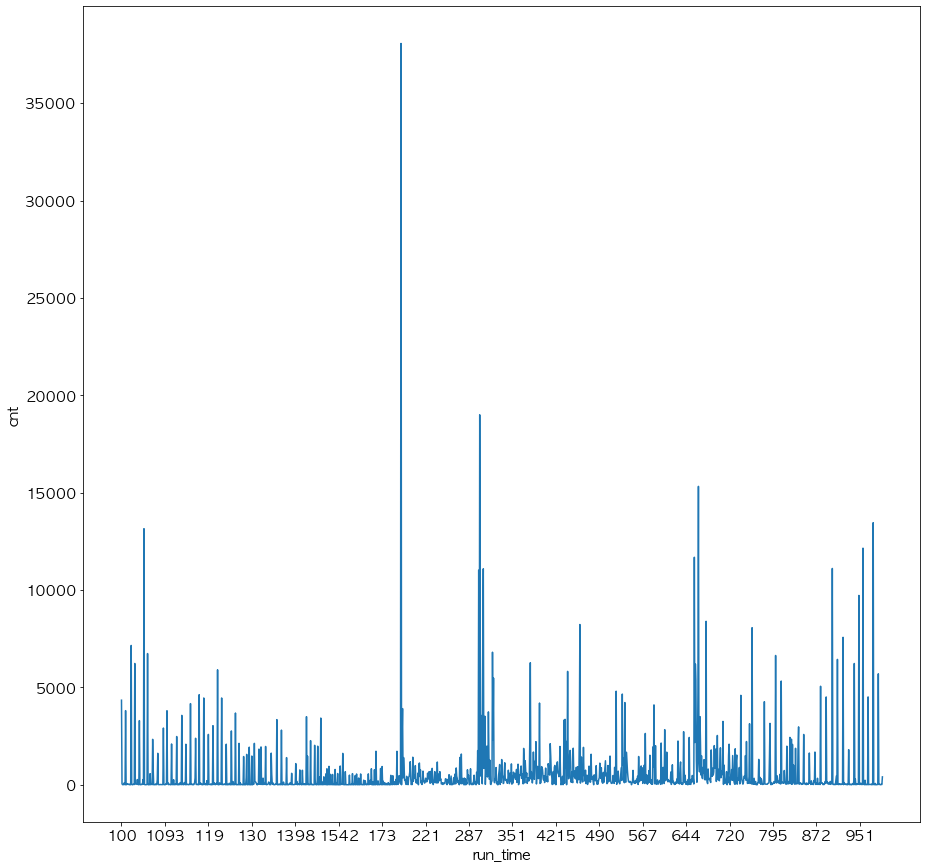

In [165]:
# 전체 컨텐츠 영상 시간별 cnt 비교
plt.figure(figsize=(15,15))
sns.lineplot(x='run_time',y='cnt',data=watch_e_meta_profile_runtimepercent_groupby)
plt.xticks(range(0,len(watch_e_meta_profile_runtimepercent_groupby),85))
plt.show()

In [166]:
# 유저 시청시간과 컨텐츠 전체 영상 길이 퍼센트화 및 컨테츠별 퍼센트 평균
watch_e_meta_profile_runtimepercent_mean = watch_e_meta_profile_runtimepercent.groupby(['album_id']).mean()['runtime_percent'].reset_index().rename(columns={'runtime_percent':'runtime_percent_mean'})
watch_e_meta_profile_runtimepercent_mean = watch_e_meta_profile_runtimepercent_mean.sort_values(by='album_id')
watch_e_meta_profile_runtimepercent_mean['album_id'] = watch_e_meta_profile_runtimepercent_mean['album_id'].astype(str)

In [167]:
# 평균적으로 컨텐츠는 0.6 이상 봄
watch_e_meta_profile_runtimepercent_mean.describe()

,runtime_percent_mean
count,20361.000000
mean,0.602252
std,0.319543
min,0.000000
25%,0.385485
50%,0.648990
75%,0.844093
max,5.766667


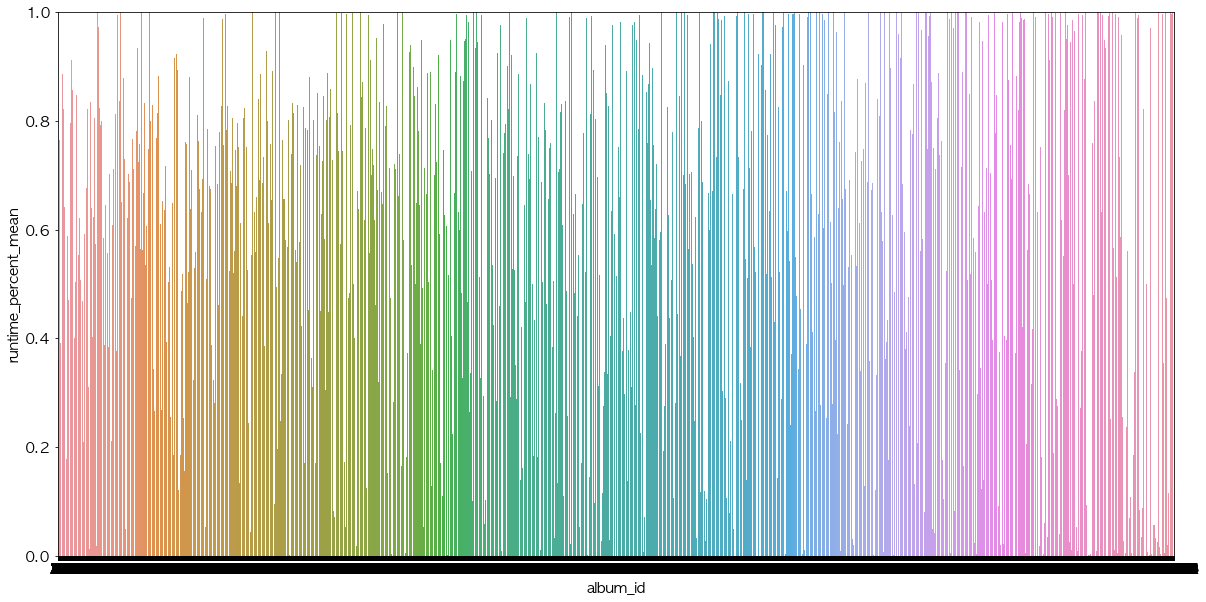

In [168]:
# 앨범 컨텐츠 당 전체 컨테츠 길이 분의 유저 평균 시청 평균
plt.figure(figsize=(20,10))
sns.barplot(x='album_id',y='runtime_percent_mean',data=watch_e_meta_profile_runtimepercent_mean)
plt.ylim([0,1])
plt.show()

- 영상 길이가 길면 어쩔 수 없게 퍼센트도 떨어질 것이라고 생각됨
- 따라서 영상 길이가 좀 적은 것에 대해서 퍼센트 비교 후 neg 가능 예상

## 2. MP 확인

In [176]:
history_meta_profile_duplicate_df.groupby(['title','genre_large']).count()['profile_id'].reset_index().rename(columns={'profile_id':'cnt'})

,title,genre_large,cnt
0,"1, 2 뭘 하면 좋을 까요?2",키즈,3
1,"1, 2, 3, 4, 5 그리고 0",키즈,5
2,"1, 2, 3, 누구일까요?",키즈,33
3,"1,2 무엇을 할까요",키즈,495
4,"1,2,3,4,5 내가 잡은 물고기",키즈,86
...,...,...,...
19258,힘이 사라진다면?,키즈,29
19259,힘이 센 이유,키즈,2
19260,힘이 쎈 화물기차!,키즈,13
19261,힙실로포돈류 공룡이 궁금해요,키즈,2


## 3. buy data pay 이용한 neg sampling 구하기

###  유저별로 경향 살펴 보기 

In [23]:
# ss_id 처음 영상 시청시작 시간이고 log time은 각각 시작 종료 시간임 이 시간으로 watch_itme 계산됨
display(history_df[(history_df['profile_id']==3)&(history_df['album_id']==20)])
display(watch_e_df[(watch_e_df['profile_id']==3) & (watch_e_df['album_id']==20)])

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
5,3,20220301115653,20220301120450,MKID003,20,NaN,Y,N
18,3,20220301115653,20220301123156,MKID003,20,NaN,Y,N


,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
5,3,20220301115653,20220301120650,MKID049,20,119,119,1
18,3,20220301115653,20220301123408,MKID049,20,119,119,1


In [24]:
# watch time 15초 인것들은 예고편인 것 같은
# 예고편만 보는 경우인 것 같음 이런 것은 전처리 혹은 neg sampling 해야되지 않을 지..
display(histhistory_dfory_df[(history_df['profile_id']==5)&(history_df['album_id']==317)])
display(watch_e_df[(watch_e_df['profile_id']==5)&(watch_e_df['album_id']==317)])

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
562,5,20220426111949,20220426114735,MKID003,317,NaN,Y,Y
563,5,20220426111949,20220426114752,MKID003,317,NaN,Y,Y
564,5,20220426111949,20220426114809,MKID003,317,NaN,Y,Y
565,5,20220426111949,20220426114826,MKID003,317,NaN,Y,Y
566,5,20220426111949,20220426114843,MKID003,317,NaN,Y,Y
567,5,20220426111949,20220426114859,MKID003,317,NaN,Y,Y
568,5,20220426111949,20220426114916,MKID003,317,NaN,Y,Y
569,5,20220426111949,20220426114935,MKID003,317,NaN,Y,Y
570,5,20220426111949,20220426114952,MKID003,317,NaN,Y,Y


,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
553,5,20220426111949,20220426114750,MKID049,317,15,90,1
554,5,20220426111949,20220426114807,MKID049,317,15,88,1
555,5,20220426111949,20220426114824,MKID049,317,15,88,1
556,5,20220426111949,20220426114841,MKID049,317,15,88,1
557,5,20220426111949,20220426114858,MKID049,317,15,90,1
558,5,20220426111949,20220426114915,MKID049,317,15,88,1
559,5,20220426111949,20220426114932,MKID049,317,15,90,1
560,5,20220426111949,20220426114951,MKID049,317,15,88,1
561,5,20220426111949,20220426115006,MKID049,317,13,88,0


### MP 컨텐츠

In [82]:
# 같은 시간에 시청한 같은 영상 시청한 것 만 제외 (TV, 스마트폰 두개 로 또같은거 틀어놓은 것 같음)
history_duplicate_df = history_df.drop_duplicates(subset=['profile_id','log_time','album_id'])
print('전처리 전 데이터 수:', len(history_df), '전처리 후 데이터 수:', len(history_duplicate_df))

전처리 전 데이터 수: 1005651 전처리 후 데이터 수: 899252


In [81]:
history_duplicate_df.album_id.value_counts()

16       11620
15        7880
19        6403
17        5937
124       5875
         ...  
21499        1
21502        1
20894        1
21506        1
25916        1
Name: album_id, Length: 20695, dtype: int64

### 전체적인 시청 시간

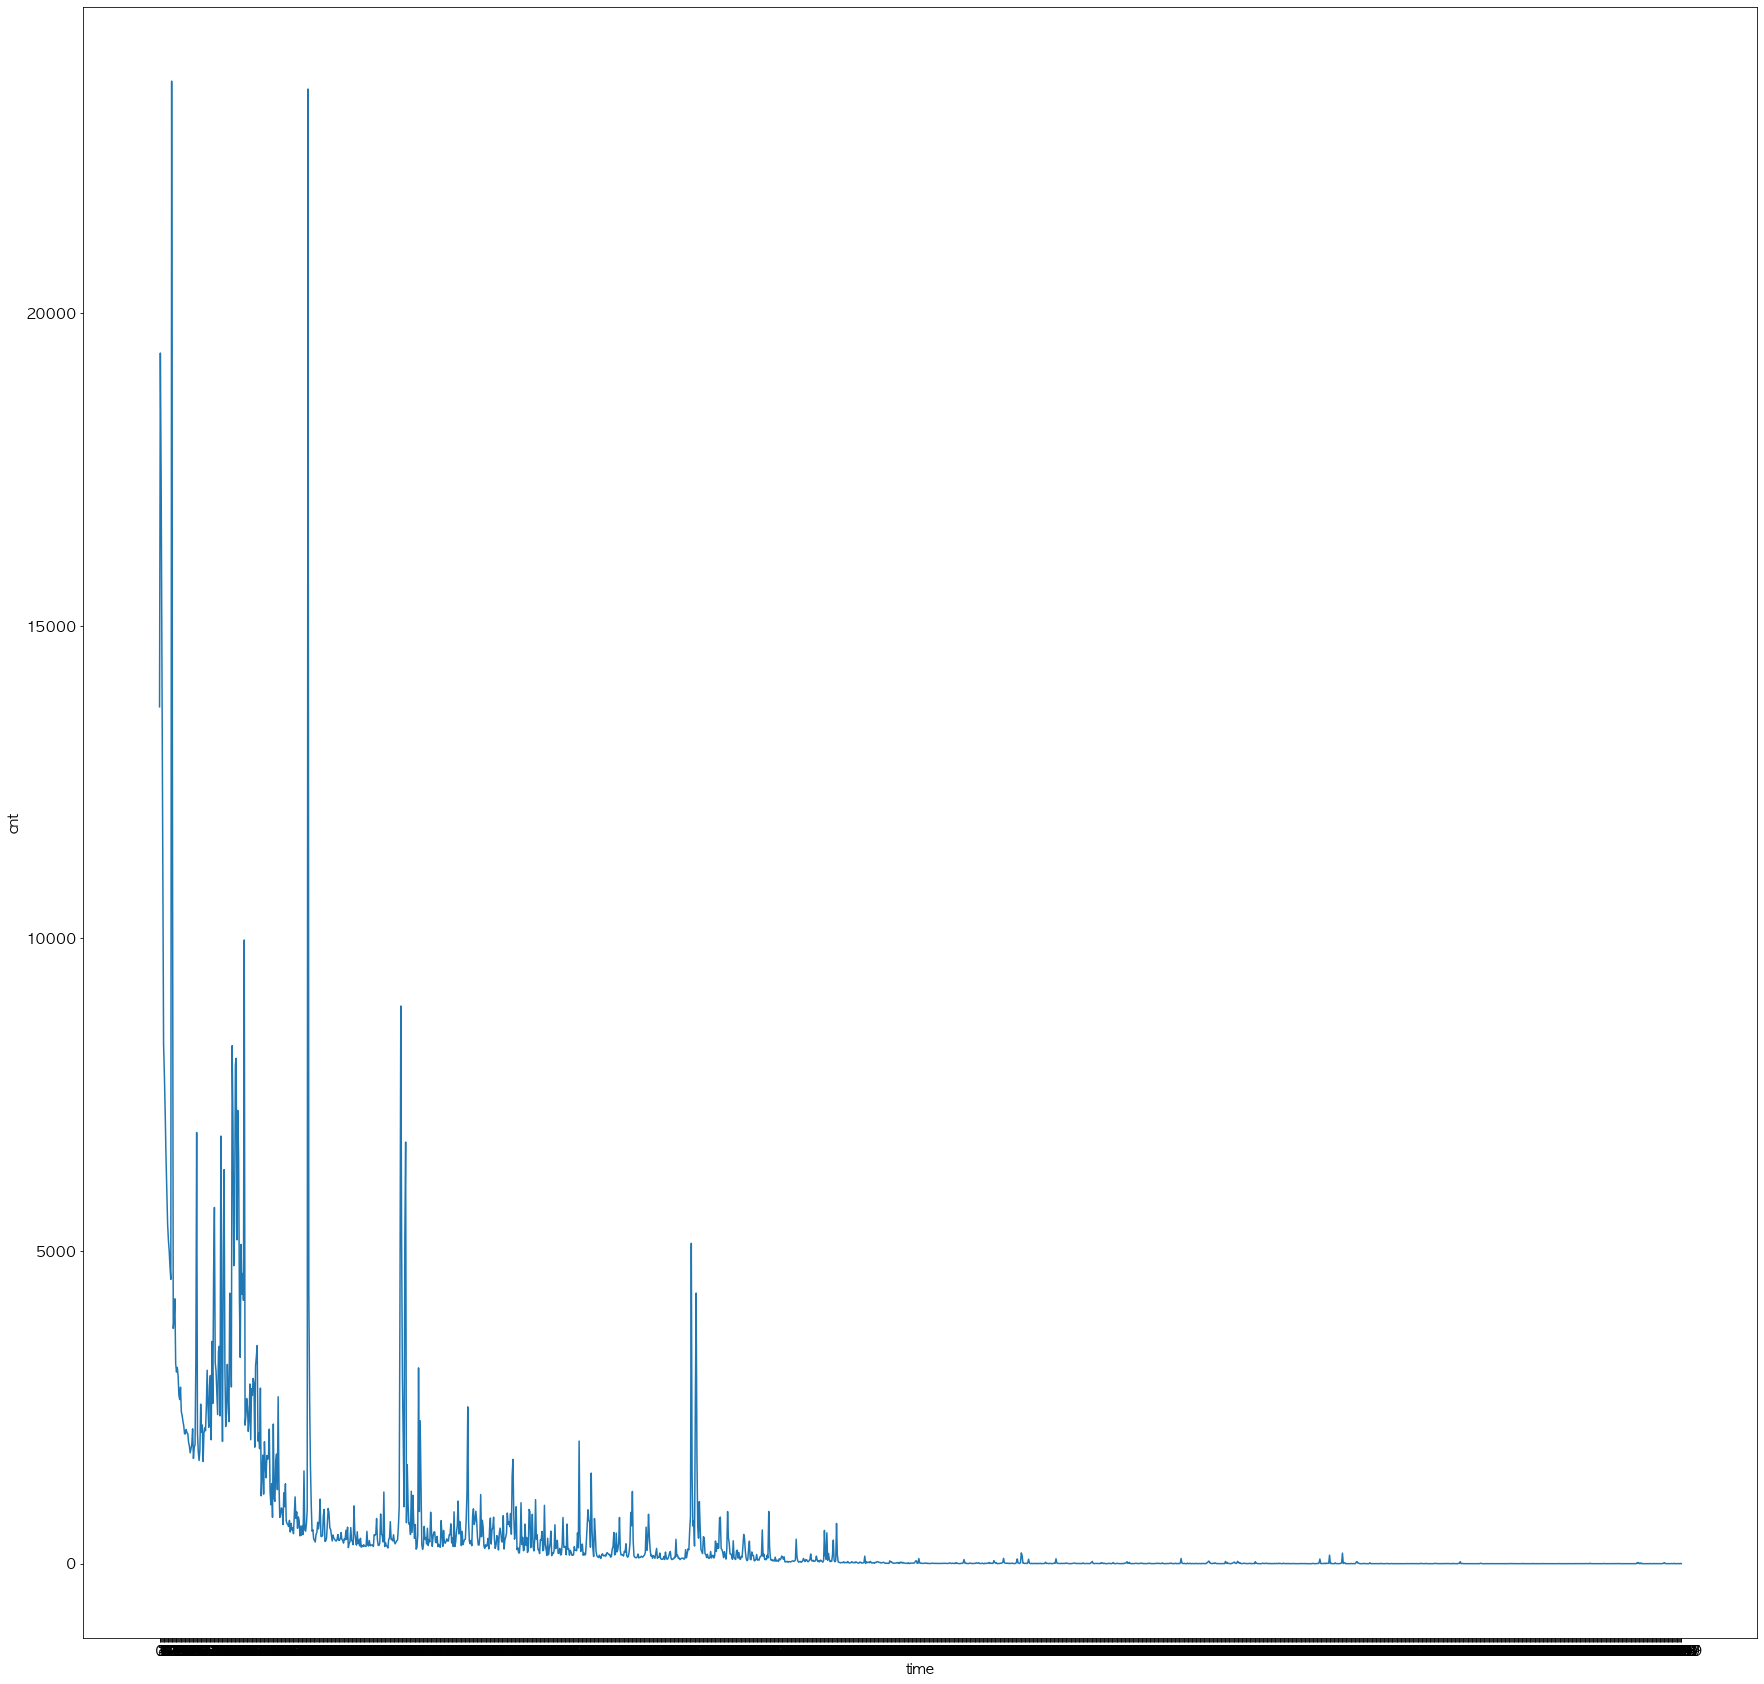

In [53]:
plt.figure(figsize=(30,30))
watch_time_cnt = watch_e_df.watch_time.value_counts()
watch_time_cnt_df = watch_time_cnt.reset_index().rename(columns={'index':'time','watch_time':'cnt'})
watch_time_cnt_sort_df = watch_time_cnt_df.sort_values(by='time')
watch_time_cnt_sort_df['time'] = watch_time_cnt_sort_df['time'].astype(str)
sns.lineplot(data=watch_time_cnt_sort_df, x=watch_time_cnt_sort_df.time, y=watch_time_cnt_sort_df.cnt)
plt.show()

In [56]:
watch_time_cnt_df.head(10)

,time,cnt
0,15,23712
1,184,23586
2,1,19363
3,2,17318
4,3,14344
5,0,13705
6,16,12225
7,4,11773
8,105,9976
9,299,8920


In [218]:
# album 317 예고편만 있는 것은 아닌가?
history_df[(history_df['album_id']==317)&(history_df['short_trailer']=='N')].head()
# 아니였음

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
59077,1852,20220322202032,20220322202304,MKID003,317,NaN,Y,N
153621,3543,20220313094621,20220313100239,MKID003,317,NaN,Y,N
220115,4830,20220314144759,20220314151804,MKID003,317,500.0,Y,N
227190,5117,20220424164845,20220424173303,MKID003,317,NaN,Y,N
423236,10225,20220303071654,20220303072354,MKID003,317,NaN,Y,N


In [226]:
# album 317 예고편 이후 시청 시간도 기록되는가?
history_df[(history_df['album_id']==1)&(history_df['short_trailer']=='Y')].head()

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
714020,18992,20220315124601,20220315185853,MKID003,1,NaN,Y,Y
714021,18992,20220315124601,20220315185853,MKID003,1,NaN,Y,Y
855492,23650,20220312181321,20220313193736,MKID003,1,NaN,Y,Y


In [227]:
# 기록되는 것으로 확인
watch_e_df[(watch_e_df['profile_id']==18992)&(watch_e_df['album_id']==1)]

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
636316,18992,20220315124601,20220315185934,MKID049,1,2,62,0
636317,18992,20220315124601,20220315185934,MKID049,1,2,62,0


In [57]:
# 기록되는 것으로 확인
watch_e_df[(watch_e_df['profile_id']==23650)&(watch_e_df['album_id']==1)]

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
758555,23650,20220312181321,20220313193739,MKID049,1,3,62,0


In [72]:
# album 317 예고편 이후 시청 시간도 기록되는가?
history_df[(history_df['album_id']==321)&(history_df['short_trailer']=='Y')].head()

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
742697,19963,20220419140902,20220419152216,MKID003,321,NaN,N,Y
876824,24743,20220410065940,20220410071547,MKID003,321,NaN,Y,Y


In [74]:
# 예고편이 있으면 다 시청시간이 낮음
# album_id 자체가 예고편으로도 생성되는 것 같음
watch_e_df[(watch_e_df['profile_id']==24743)&(watch_e_df['album_id']==321)]

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
777996,24743,20220410065940,20220410071552,MKID049,321,4,327,0


In [19]:
display(history_df[(history_df['profile_id']==5)&(history_df['album_id']==65)])
display(watch_e_df[(watch_e_df['profile_id']==5) & (watch_e_df['album_id']==65)])

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
21,5,20220302203651,20220302203754,MKID003,65,NaN,Y,N
25,5,20220302215129,20220304160953,MKID003,65,NaN,Y,N
190,5,20220318212718,20220319095026,MKID003,65,NaN,Y,N


,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
20,5,20220302203651,20220302203824,MKID049,65,30,536,0
24,5,20220302215129,20220304181215,MKID049,65,242,536,0
189,5,20220318212718,20220319095056,MKID049,65,30,536,0


### short trailer 연관성 살펴보기

In [219]:
# 예고편보다는 영상을 많이 봄
# 예고편 영상 
history_df.short_trailer.value_counts()

N    945784
Y     59867
Name: short_trailer, dtype: int64

### payment 연관성 살펴보기

In [12]:
history_df_prepro = history_df.copy()

In [121]:
buy_album_history_df = history_df_prepro[history_df_prepro['album_id'].isin(list(buy_df.album_id.unique()))]
# buy_album_history_df.payment.value_counts()
buy_album_history_df['payment'] = buy_album_history_df['payment'].fillna(0)
buy_album_history_df['pay_true_false'] = buy_album_history_df['payment'].apply(lambda x: 0 if x == 0 else 1)
visualize_buy_album = buy_album_history_df.groupby(['album_id','pay_true_false']).count().iloc[:,0:1].rename(columns={'profile_id':'cnt'}).reset_index()

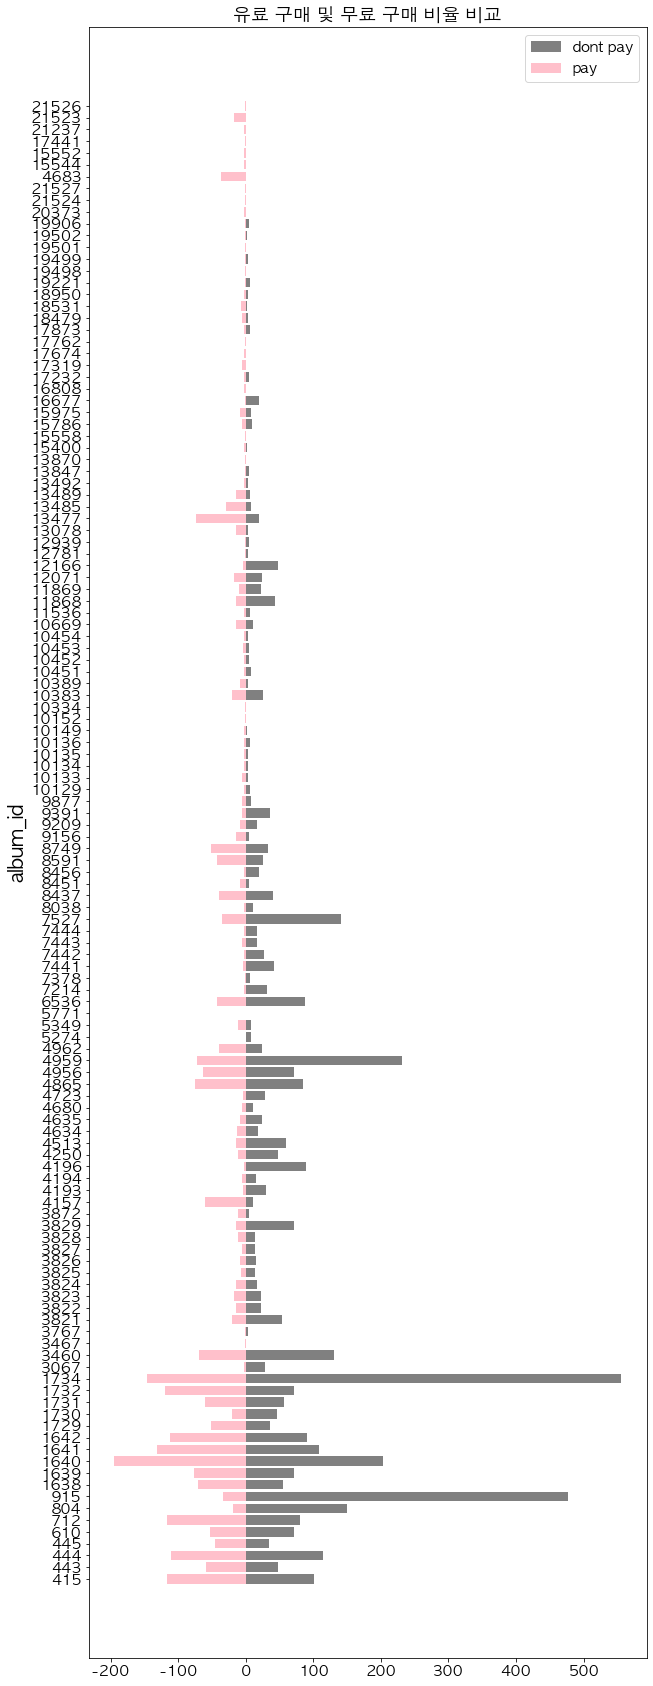

In [116]:
plt.figure(figsize=(10,30))
visualize_buy_album['album_id'] = visualize_buy_album['album_id'].astype(str)
album_id = visualize_buy_album.album_id
y = visualize_buy_album[visualize_buy_album['pay_true_false']==0]
y1 = visualize_buy_album[visualize_buy_album['pay_true_false']==1]
plt.barh(y.album_id, y.cnt, color='gray', label='무료')
plt.barh(y1.album_id, -y1.cnt,color='pink', label='유료')
plt.ylabel('album_id',fontsize=20)
plt.title('유료 구매 및 무료 구매 비율 비교')
plt.legend()
plt.show()

- 무료 와 유료 비율을 비교하여 candidate 설정
- 무료 > 유료 -> pos (단 데이터가 많을 경우)
- 무료 = 유료 -> pos
- 무료 < 유료 -> pos
- 무료 적고 유료 적음 -> neg
- 무료 적고 유료 많음 -> pos (안적음 ?)

# 3. 구매 이력 데이터(buy_df)

In [118]:
buy_content_rank = buy_df.profile_id.value_counts()
buy_content_rank_df = pd.DataFrame(buy_content_rank).reset_index().rename(columns={'index':'profile_id','profile_id':'cnt'})
buy_content_rank_df

,profile_id,cnt
0,10416,75
1,16379,13
2,7394,12
3,23882,11
4,5303,9
5,8410,6
6,17507,6
7,12472,5
8,15000,4
9,5629,2


In [119]:
buy_content_rank_df.describe()

,profile_id,cnt
count,17.000000,17.000000
mean,14578.117647,8.823529
std,10177.921429,17.572120
min,255.000000,1.000000
25%,7394.000000,1.000000
50%,13669.000000,4.000000
75%,17507.000000,9.000000
max,32528.000000,75.000000


# 4.유저 프로필 정보 (profile_df)

In [28]:
pr_interest_keyword_dict = {'P01':'과학기술',
                           'P02':'정서/사회성',
                           'P03':'자연탐구',
                           'P04':'바른생활/안전',
                           'P05':'활동/운동',
                           'P06':'음악예술',
                           'P07':'언어논리',
                           'P08':'수리논리'}
ch_interest_keyword_dict = {'K01':'노래/율동',
                           'K02':'동물/식물',
                           'K03':'동화',
                           'K04':'만들기',
                           'K05':'숫자/계산',
                           'K06':'외국어',
                           'K07':'친구/사람',
                           'K08':'탈것/기계',
                           'K09':'활동/운동'}

pr_list = ['pr_interest_keyword_cd_1','pr_interest_keyword_cd_2','pr_interest_keyword_cd_3']
ch_list = ['ch_interest_keyword_cd_1','ch_interest_keyword_cd_2','ch_interest_keyword_cd_3']
for pr in pr_list:
    profile_df[pr] = profile_df[pr].apply(lambda x: pr_interest_keyword_dict.get(x, np.NaN))
for ch in ch_list:
    profile_df[ch] = profile_df[ch].apply(lambda x: ch_interest_keyword_dict.get(x, np.NaN))
    

In [29]:
pr1 = profile_df.pr_interest_keyword_cd_1.value_counts()
pr2 = profile_df.pr_interest_keyword_cd_2.value_counts()
pr3 = profile_df.pr_interest_keyword_cd_3.value_counts()

ch1 = profile_df.ch_interest_keyword_cd_1.value_counts()
ch2 = profile_df.ch_interest_keyword_cd_2.value_counts()
ch3 = profile_df.ch_interest_keyword_cd_3.value_counts()

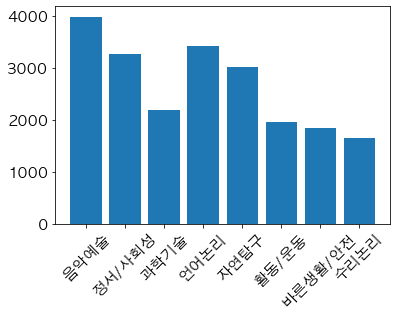

In [30]:
pr_total_cnt = pd.DataFrame([pr1,pr2,pr3]).sum(axis=0)
plt.bar(pr_total_cnt.index, pr_total_cnt.values)
plt.xticks(rotation=45)
plt.show()

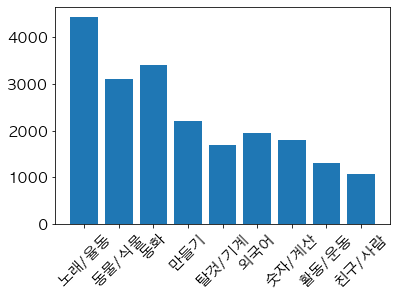

In [31]:
ch_total_cnt = pd.DataFrame([ch1,ch2,ch3]).sum(axis=0)
plt.bar(ch_total_cnt.index, ch_total_cnt.values)
plt.xticks(rotation=45)
plt.show()

In [33]:
profile_df.profile_id.nunique(), len(profile_df)

(8311, 8311)

프로필 중복되거나 하지는 않음

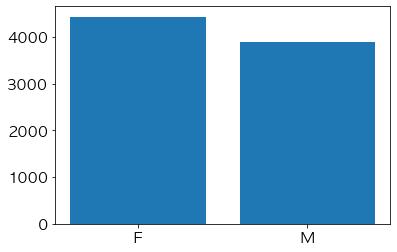

In [34]:
sex_bar = profile_df.sex.value_counts()
plt.bar(sex_bar.index, sex_bar.values)
plt.show()

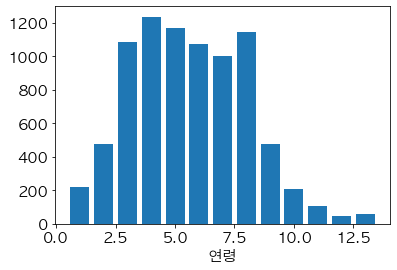

In [35]:
age_bar = profile_df.age.value_counts()
plt.bar(age_bar.index,age_bar.values)
plt.xlabel('연령')
plt.show()

한국 초등학교 입학 연령은 8살(만) 이지만 개정이 얼마 되지 않았기 때문에   
초등학교 입학 이후 급격하게 줄어드는 것을 확인할 수 있음

### 5-1 장르별 컨텐츠 개수

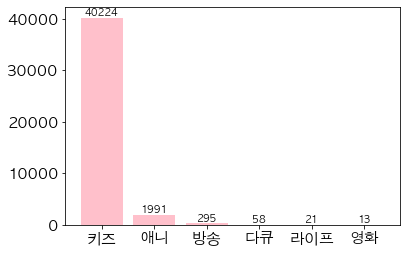

In [89]:
genre_large = meta_df.genre_large.value_counts()
bar = plt.bar(genre_large.index,genre_large.values, color='pink')
# 숫자 넣는 부분
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.0f' % height, ha='center', va='bottom', size = 10)
plt.show()

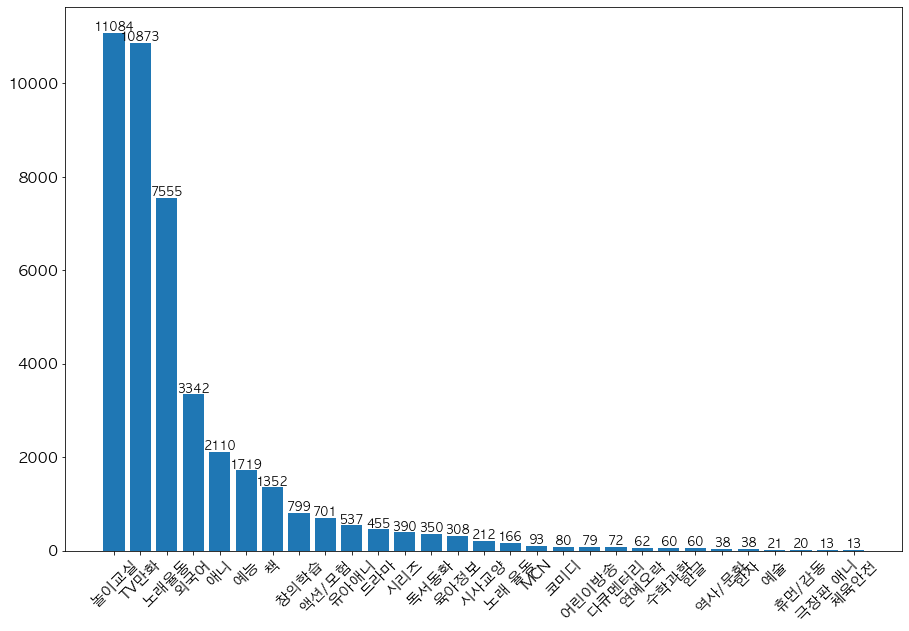

In [84]:
plt.figure(figsize=(15,10))
genre_mid = meta_df.genre_mid.value_counts()
bar = plt.bar(genre_mid.index,genre_mid.values)
plt.xticks(rotation=45)
# 숫자 넣는 부분
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.0f' % height, ha='center', va='bottom', size = 12)
plt.show()

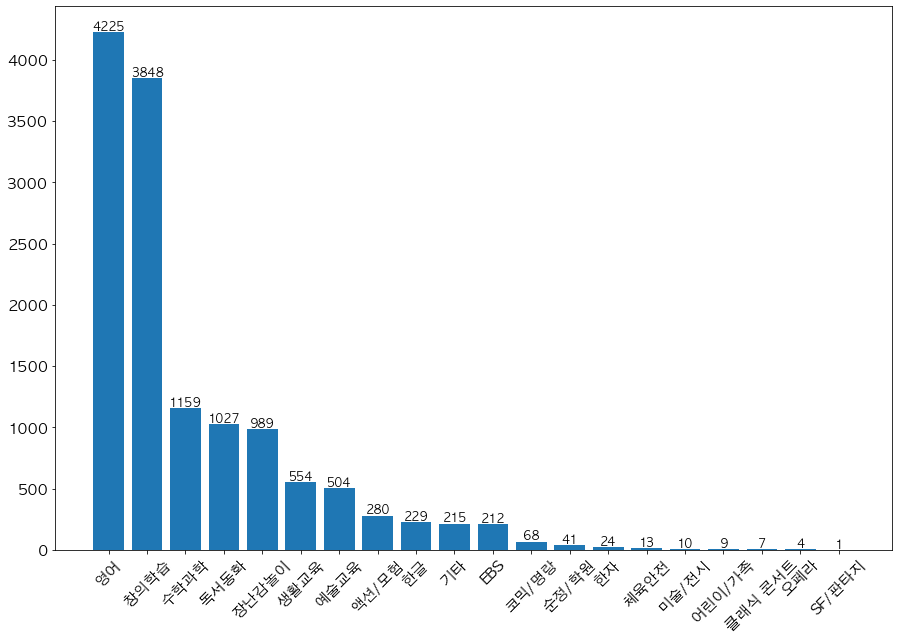

In [82]:
plt.figure(figsize=(15,10))
genre_small = meta_df.genre_small.value_counts()
bar = plt.bar(genre_small.index,genre_small.values)
plt.xticks(rotation=45)
# 숫자 넣는 부분
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.0f' % height, ha='center', va='bottom', size = 12)
plt.show()

### 5-2 시청 기록 데이터와 meta album 비교

In [92]:
print('전체 컨테츠 중 시청 기록 데이터에 없는 컨텐츠 수:',len(set(duplicate_meta_df.album_id)-set(history_df.album_id)))

전체 컨테츠 중 시청 기록 데이터에 없는 컨텐츠 수: 19180


In [93]:
print('전체 컨텐츠 중 시청 기록에만 있는 컨텐츠 수:', set(history_df.album_id)- set(duplicate_meta_df.album_id))

전체 컨텐츠 중 시청 기록에만 있는 컨텐츠 수: set()


- 시작 데이터에는 19180 컨텐츠가 콜드임
- 메타 데이터에 없는 컨텐츠가 시작 데이터에 있지는 않음

In [94]:
print('전체 컨테츠 중 종료 기록 데이터에 없는 컨텐츠 수:', len(set(duplicate_meta_df.album_id)-set(watch_e_df.album_id)))

전체 컨테츠 중 종료 기록 데이터에 없는 컨텐츠 수: 19514


In [95]:
print('전체 컨텐츠 중 종료 기록에만 있는 컨텐츠 수:',set(watch_e_df.album_id) - set(duplicate_meta_df.album_id))

전체 컨텐츠 중 종료 기록에만 있는 컨텐츠 수: set()


- 종료 데이터에는 19514 컨텐츠가 콜드
- 메타 데이터에 없는 컨텐츠가 종료 데이터에 있지는 않음